# Multitouch Attribution Modeling (EDA)

## 1. Goal of the project

The goal of this multi-touch attribution modelling is to understand the impact of each touchpoint in the customer journey with various digital online channels.

## 2. Overview data
This notebook analyses the data retrieved from [Kaggle](https://www.kaggle.com/datasets/vivekparasharr/multi-touch-attribution/data). 

The dataset contains 10,000 rows of marketing interaction data, designed to support multi-touch attribution (MTA) analysis. It records user interactions with various marketing channels and campaigns over a two-day period (February 10-11, 2025), along with conversion outcomes.

Columns of the dataset:

| Column name | Description |
| --- | ----------- |
| User ID | A unique identifier for each customer.|
| Timestamp | The exact date and time of the interaction.|
| Channel | The marketing channel where the interaction occurred.|
| Campaign | The specific marketing campaign associated with the interaction. ‘-’ indicates no campaign.|
| Conversion | Indicates whether the user converted (Yes) or not (No). |

The data does not contain any information if the contact was an impression or a click.

Key Insights:  
• Unique Users: 2,847  
• Most Frequent Channel: Direct Traffic (~17.2%)  
• Campaign Involvement: 31.3% of interactions had no campaign assigned.  
• Conversion Rate: 49.44% of interactions resulted in a conversion.  

In [1]:
# import the necessary libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.preprocessing import OneHotEncoder
from marketing_attribution_models import *

In [2]:
# read in csv file and display first 5 rows of the datset
df = pd.read_csv("../data/raw/multi_touch_attribution_data.csv")
df.head()

,User ID,Timestamp,Channel,Campaign,Conversion
0,83281,2025-02-10 07:58:51,Email,New Product Launch,No
1,68071,2025-02-10 23:38:48,Search Ads,Winter Sale,No
2,90131,2025-02-11 10:41:07,Social Media,Brand Awareness,Yes
3,71026,2025-02-10 08:19:44,Direct Traffic,-,Yes
4,94486,2025-02-10 15:15:46,Email,Retargeting,Yes


In [3]:
# Shape of the dataset
df.shape

(10000, 5)

In [4]:
# Check out our data-types
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   User ID     10000 non-null  int64 
 1   Timestamp   10000 non-null  object
 2   Channel     10000 non-null  object
 3   Campaign    10000 non-null  object
 4   Conversion  10000 non-null  object
dtypes: int64(1), object(4)
memory usage: 390.8+ KB


In [5]:
# Changing the type of the column Timestamp to a datetime format
df['Timestamp'] = pd.to_datetime(df['Timestamp'])

In [6]:
# Changing the type of the column User ID to a string format
df['User ID'] = df['User ID'].astype(str)

In [7]:
# Changing the column Conversion to a Boolean format
df['Conversion'] = df['Conversion'].map({'Yes': 1, 'No': 0})

In [8]:
# Renaming the columns
df = df.rename(columns={
    'User ID': 'customer_id',
    'Timestamp': 'event_date',
    'Channel': 'channel_name',
    'Campaign': 'campaign',
    'Conversion': 'conversion'
})

In [9]:
# Checking for missing values
df.isnull().sum()

customer_id     0
event_date      0
channel_name    0
campaign        0
conversion      0
dtype: int64

There are no missing values in the dataset.

In [10]:
# Checking the number of unique user ids in the whole dataset:
unique_uids=df['customer_id'].unique()
print(f"There are {len(unique_uids)} unique user ids in the dataset.")

There are 2847 unique user ids in the dataset.


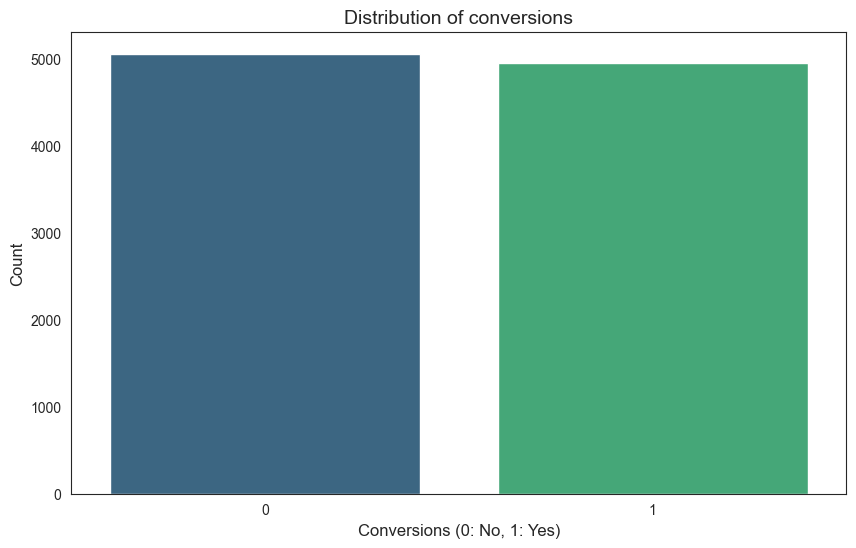

In [11]:
# Checking how many of the contacts resulted in (not unique) conversions
conversion_counts = df['conversion'].value_counts()

plt.figure(figsize=(10,6))
sns.barplot(x=conversion_counts.index, y=conversion_counts.values, palette="viridis")
plt.title("Distribution of conversions", fontsize=14)
plt.xlabel("Conversions (0: No, 1: Yes)", fontsize=12)
plt.ylabel("Count", fontsize=12)
plt.show()

     channel_name  total_events  total_conversions
0  Direct Traffic          1721                853
1     Display Ads          1669                828
2           Email          1654                830
3        Referral          1685                841
4      Search Ads          1609                772
5    Social Media          1662                820


<Figure size 640x480 with 0 Axes>

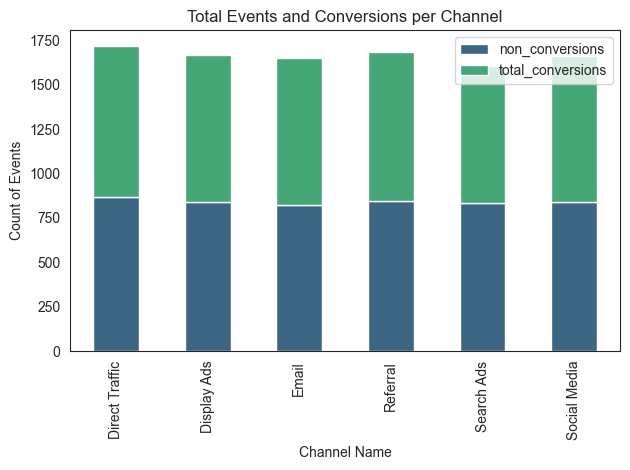

In [12]:
# Distribution of channels
channel_stats = df.groupby('channel_name').agg(
    total_events=('conversion', 'size'),
    total_conversions=('conversion', 'sum')
).reset_index()
print(channel_stats)

channel_stats['non_conversions'] = channel_stats['total_events'] - channel_stats['total_conversions']
channel_stats.set_index('channel_name', inplace=True)

plt.figure()
channel_stats[['non_conversions', 'total_conversions']].plot(
    kind='bar',
    stacked=True,
    color=['#3c6682', '#45a778']
)
plt.xlabel('Channel Name')
plt.ylabel('Count of Events')
plt.title('Total Events and Conversions per Channel')
plt.tight_layout()
plt.show()

             campaign  total_events  total_conversions
0                   -          3131               1552
1     Brand Awareness          1378                698
2      Discount Offer          1324                668
3  New Product Launch          1416                676
4         Retargeting          1379                683
5         Winter Sale          1372                667


<Figure size 640x480 with 0 Axes>

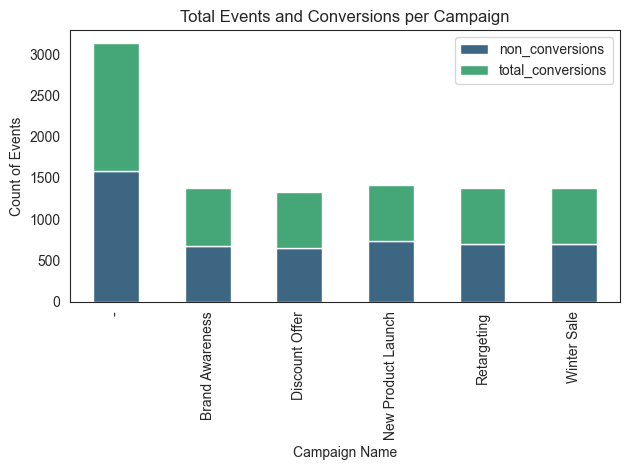

In [13]:
# Distribution of campaign
campaign_stats = df.groupby('campaign').agg(
    total_events=('conversion', 'size'),
    total_conversions=('conversion', 'sum')
).reset_index()
print(campaign_stats)

campaign_stats['non_conversions'] = campaign_stats['total_events'] - campaign_stats['total_conversions']
campaign_stats.set_index('campaign', inplace=True)

plt.figure()
campaign_stats[['non_conversions', 'total_conversions']].plot(
    kind='bar',
    stacked=True,
    color=['#3c6682', '#45a778']
)
plt.xlabel('Campaign Name')
plt.ylabel('Count of Events')
plt.title('Total Events and Conversions per Campaign')
plt.tight_layout()
plt.show()

In [14]:
# Calculating the absolute number of conversions grouped by customer ID (counting only one conversion per journey)

customer_conversion_flag = (
    df
    .groupby('customer_id')['conversion']
    .any()                 # True, wenn mindestens eine 1 vorkommt
    .astype(int)           # True/False → 1/0
    .reset_index(name='converted')
)

print(customer_conversion_flag.head())


  customer_id  converted
0       10028          1
1       10045          1
2       10062          1
3       10068          1
4       10095          1


In [15]:
user_conversions = (
    customer_conversion_flag
    .agg(total_conversions=('converted', 'sum'))
    .reset_index()
)
print(f"The absolute number of conversions is {user_conversions.iloc[0,1]}.")

The absolute number of conversions is 2381.


In [16]:
# Total number of customer journeys
total_journeys = customer_conversion_flag.shape[0]
print(total_journeys)
# Total of conversions
total_conversions = customer_conversion_flag['converted'].sum()
# Gesamtzahl der Nicht-Conversions
total_non_conversions = total_journeys - total_conversions

print(f"The absolute number of conversions is {total_conversions}.")
print(f"The absolute number of non-conversions is {total_non_conversions}.")


2847
The absolute number of conversions is 2381.
The absolute number of non-conversions is 466.


For the modeling, it is important to have at least two contacts in order to evaluate different attribution models. So, we analyze the data with regards to the chain length within the customer journey that led to a conversion.

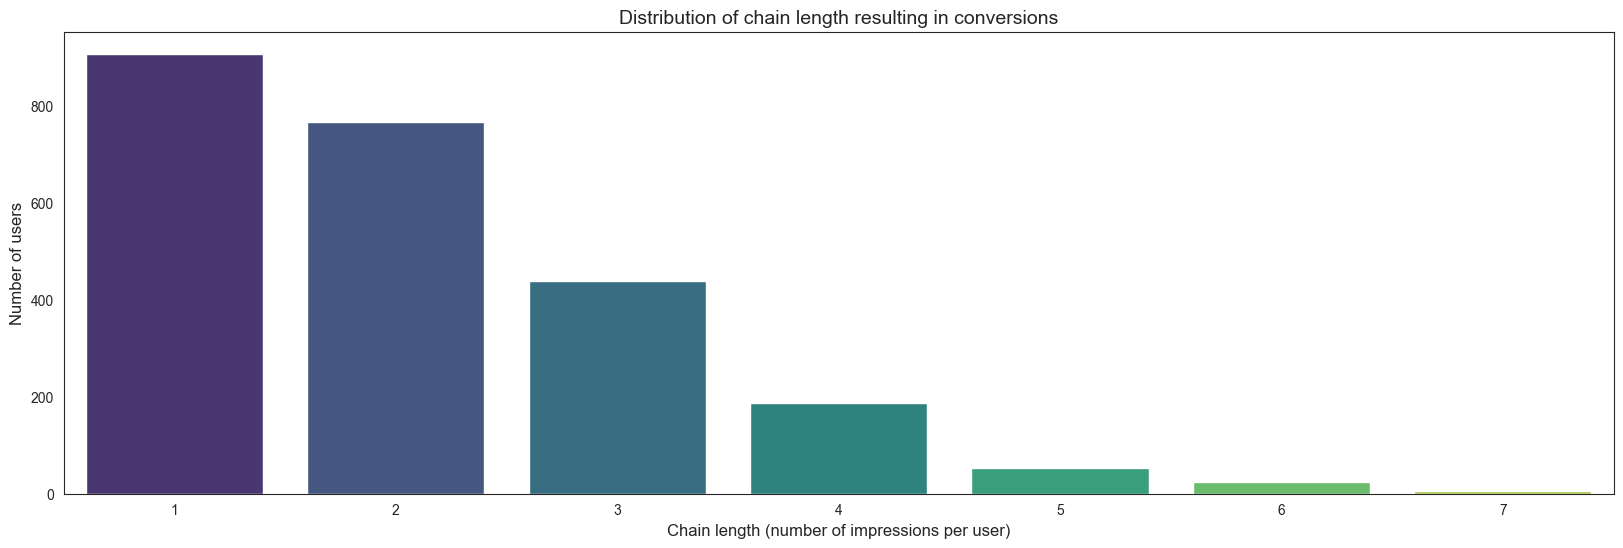

In [17]:
df_conversions = df[df['conversion']==1].copy()

chain_lengths = df_conversions['customer_id'].value_counts()
length_distribution = chain_lengths.value_counts().sort_index()

plt.figure(figsize=(20,6))
sns.barplot(x = length_distribution.index, y = length_distribution.values, palette="viridis")

plt.title("Distribution of chain length resulting in conversions", fontsize = 14)
plt.xlabel("Chain length (number of impressions per user)", fontsize = 12)
plt.ylabel("Number of users", fontsize = 12)

plt.show()

The graph shows, that most of the chains have only one contact, so we have to keep that in mind for the further analysis. As there are a lot of chains with only one contact, we won't remove those users to avoid information loss and maybe underestimate the importance of channels which might need only one contact.

## 6. Data Pre-Processing: Creating a DataFrame for the DP6 Attribution Package

With the help of the DP6 attribution package, we can use simple heuristic models as a starting point.

The data frame has to contain the following columns: user_id, event_date (timestamp of contact), channel and conversion.

In [ ]:
# 1. Sorting according to user and date
df = df.sort_values(["customer_id", "event_date"])

# Creating a touchpoint label
#df["touch"] = df["channel_name"] + "_" + df["campaign"]

# Summing up the sequences per user
seq_df = (
    df.groupby("customer_id")
      .agg(
          path=("channel_name", lambda x: " > ".join(x)),
          conversion=("conversion", "max")
      )
      .reset_index()
)

# Checking length of sequence
seq_df["touch_count"] = seq_df["path"].str.count(" > ") + 1

# Overview single versus multi touch
counts = seq_df["touch_count"].value_counts().sort_index()
print("Touchpoint-Verteilung pro Nutzer:")
print(counts)

# seq_df ist nun in der Form, die das DP6 Attribution Package erwartet:
# Spalten: customer_id, path, conversion[, touch_count]

Touchpoint-Verteilung pro Nutzer:
touch_count
1     343
2     584
3     595
4     563
5     383
6     224
7      92
8      37
9      16
10      4
11      3
12      3
Name: count, dtype: int64


c:\Users\Maria\Desktop\ds_projects\attribution\.venv\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


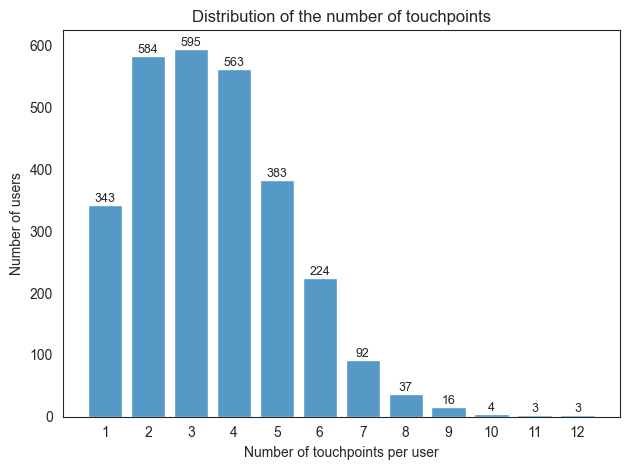

In [19]:
ax = sns.histplot(data=seq_df, x="touch_count", binwidth=1, discrete=True, shrink=0.8, bins=12)

# Bar labels
for p in ax.patches:
    height = p.get_height()
    if height:
        ax.annotate(
            f'{int(height)}',      
            (p.get_x() + p.get_width()/2, height),
            ha='center',
            va='bottom',
            fontsize= 9
        )

# x axis: Tick labels
centers = [p.get_x() + p.get_width()/2 for p in ax.patches]
# Labels als ganze Touch-Count-Werte (je nachdem, wie Deine Werte aussehen)
labels  = [str(int(center)) for center in centers]

ax.set_xticks(centers)
ax.set_xticklabels(labels)

plt.xlabel("Number of touchpoints per user")
plt.ylabel("Number of users")
plt.title("Distribution of the number of touchpoints")
plt.tight_layout()
plt.show()

In [20]:
seq_df.head()

,customer_id,path,conversion,touch_count
0,10028,Search Ads > Display Ads,1,2
1,10045,Search Ads > Display Ads,1,2
2,10062,Social Media > Direct Traffic > Email,1,3
3,10068,Search Ads > Social Media > Social Media > Sea...,1,5
4,10095,Display Ads > Email > Referral > Display Ads >...,1,6


## 7. Saving the subset of the data as csv

### 7.1 Saving a version with only customer journeys with at least two contacts

In [21]:
# Saving a version with only customer journeys with at least two contacts
df_touch_count_2 = seq_df[seq_df["touch_count"]>=2].copy()
df_touch_count_2 = df_touch_count_2.drop(columns="touch_count")
df_touch_count_2.to_csv('c:/Users/Maria/Desktop/ds_projects/attribution/data/processed/pcb_subset_2contacts.csv', index=False)

### 7.2 Saving a version with all customer journeys

In [22]:
# For the modeling we drop the touch_count
seq_df = seq_df.drop(columns="touch_count")
seq_df.to_csv('../data/processed/pcb_subset.csv', index=False)